#### Jupyter notebook usage

- To execute a code block (to run a cell) hit: `shift + return` or click on the `Run` button at the top.
- After execution the circle in the top-right corner is filled grey. Once execution has finished the circle will be filled white again.

# Tag Completeness of OpenStreetMap Buildings

We will have a closer look at the buildings mapped in OSM for Berlin (our host city for [FOSSGIS 2023](https://fossgis-konferenz.de/2023/)).

Let's check the following questions:
* Which additional attributes (such as building height or levels) are mapped for buildings in Berlin?
* What is the proportion of buildings with these additional tags?

[TagInfo](https://taginfo.openstreetmap.org/keys/building#combinations) provides us with some initial numbers on the global level. Roughly 5% of all buildings in OSM have an additional tag for `building:level` and 3% the `height` tag. But how is this in your area?

## Request the ohsome API
The ohsome API lets you analyze the rich data source of the OpenStreetMap history. You can either perform analyses using a dashboard-like application, or use the ohsome API directly and work with its CSV, JSON or GeoJSON responses.

*Further Resource:* [Website](https://heigit.org/big-spatial-data-analytics-en/ohsome/) | [GitHub](https://github.com/GIScience/ohsome-api) | [API](https://oqt.ohsome.org/api/docs)

<div class="alert alert-block alert-info"><b>Tip:</b> Check <a href="https://giscience.courses-pages.gistools.geog.uni-heidelberg.de/openstreetmap-analyses-with-qgis-python-and-r/content/chapter_2/osm_data_filtering.html">this course material</a> if you need some guidance on how to filter OSM data.</div>

### Let's try it first with the ohsome Dashboard
The [ohsome Dashboard](https://ohsome.org/apps/dashboard/) generates accurate statistics about the historical development of OSM data for custom or predefined regions all over the world and relies on the ohsome API. No programming skills are needed to work with the dashboard. The ohsome Dashboard allows custom filtering of all available OpenStreetMap tags and types and includes administrative boundaries, making the selection of search areas easier. As a result you get a graphical view on the response values of your request.

1. Define your query in the dashboard.
<img src="img/ohsome_dashboard_buildings_level_query.png" width="75%">

2. Take a look at the results.
<img src="img/ohsome_dashboard_buildings_level_results.png" width="75%">

### Let's do the same with Python...
To derive the ratio we will rely on the `ratio` endpoint of the ohsome API.

In [20]:
import json
from datetime import datetime
import requests

# check the ohsome API documentation for more details on all endpoints
base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/count/ratio"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    "filter": "building=* and geometry:polygon and building!=no",
    "filter2": 'building=* and geometry:polygon and building!=no and (height=* and height!="") or (building:levels=* and building:levels!="")',
    "format": "json",
    "time": "2008-01-01/2023-01-01/P1Y",  # P1Y --> yearly time interval
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

print(json.dumps(response.json(), indent=4))  # Pretty print response

result = response.json()["ratioResult"]

{
    "attribution": {
        "url": "https://ohsome.org/copyrights",
        "text": "\u00a9 OpenStreetMap contributors"
    },
    "apiVersion": "1.9.0",
    "ratioResult": [
        {
            "timestamp": "2008-01-01T00:00:00Z",
            "value": 2372.0,
            "value2": 6.0,
            "ratio": 0.00253
        },
        {
            "timestamp": "2009-01-01T00:00:00Z",
            "value": 17906.0,
            "value2": 14.0,
            "ratio": 0.000782
        },
        {
            "timestamp": "2010-01-01T00:00:00Z",
            "value": 39522.0,
            "value2": 305.0,
            "ratio": 0.007717
        },
        {
            "timestamp": "2011-01-01T00:00:00Z",
            "value": 76293.0,
            "value2": 460.0,
            "ratio": 0.006029
        },
        {
            "timestamp": "2012-01-01T00:00:00Z",
            "value": 146518.0,
            "value2": 2933.0,
            "ratio": 0.020018
        },
        {
            "timesta

### ..and plot the results

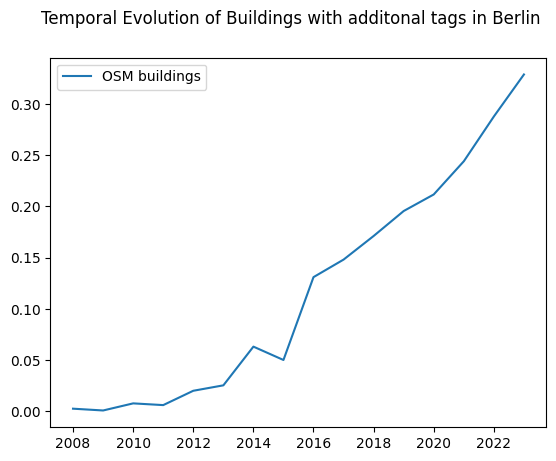

In [21]:
import matplotlib.pyplot as plt


dates = []
values = []
for r in result:
    year = datetime.fromisoformat(r["timestamp"].replace("Z", ""))
    dates.append(year)
    values.append(r["ratio"])

fig, ax = plt.subplots()
ax.plot(dates, values, label="OSM buildings")
ax.legend()
fig.suptitle("Temporal Evolution of Buildings with additonal tags in Berlin")
plt.show()

## Request the ohsome quality analyst (OQT) API

OQT provides quality estimations of OpenStreetMap (OSM) data and uses the ohsome API.

OQT calls those estimations indicators.
Indicators are computed for a specific area (`bpolys`) and a certain set of aggregated OSM features (`layer`).

OQT offers two intrinsic quality estimation: the "Mapping Saturation" indicator and the "Currentness" indicator.

*Further Resource:* [Website](https://oqt.ohsome.org) | [GitHub](https://github.com/GIScience/ohsome-quality-analyst) | [API](https://oqt.ohsome.org/api/docs)

### Tags Ratio Indicator

The Tags Ratio indicator works well with following layers, but depends a lot on your actual use case and which additional attributes you are interested in.

- Building Count (`building_count`)
- Major Roads Count (`major_roads_count`)

<div class="alert alert-block alert-info"><b>Note:</b> We are still searching for a better name for this indicator.</div>


In [4]:
# Helper function to display OQT API response.

import json

from IPython.display import SVG, display
import requests
from termcolor import colored


def display_results(feature):
    name = feature["properties"]["name"]
    label = feature["properties"]["result"]["label"]
    color = feature["properties"]["result"]["label"]
    description = feature["properties"]["result"]["description"]
    svg = feature["properties"]["result"]["svg"]

    # print(json.dumps(result, indent=4))
    print(name)
    print("-" * len(name))
    print("Quality Label: " + colored(label, color))
    print("Result Description: " + description)
    display(SVG(svg))

Berlin
------
Quality Label: yellow
Result Description: The ratio of the features (all: 488105.0) compared to features with
expected tags (matched: 162080.0) is 0.3.
Around 25-75% of the features match the expected tags.



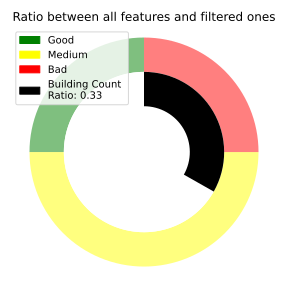

In [5]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "TagsRatio",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

display_results(response.json())

### TagsRatio Indicator for all districts in Berlin

The previous requests have been about one Area-of-Interest (AOI). OQT can compute the same Indicator for a number of AOIs given a GeoJSON FeatureCollection.

Lichtenberg
-----------
Quality Label: yellow
Result Description: The ratio of the features (all: 26163.0) compared to features with
expected tags (matched: 15369.0) is 0.6.
Around 25-75% of the features match the expected tags.



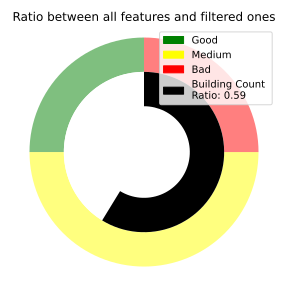

Charlottenburg-Wilmersdorf
--------------------------
Quality Label: yellow
Result Description: The ratio of the features (all: 23153.0) compared to features with
expected tags (matched: 11834.0) is 0.5.
Around 25-75% of the features match the expected tags.



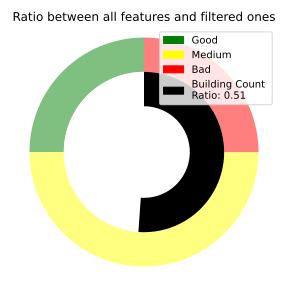

Pankow
------
Quality Label: red
Result Description: The ratio of the features (all: 65818.0) compared to features with
expected tags (matched: 13079.0) is 0.2.
Less than 25% of the features match the expected tags.



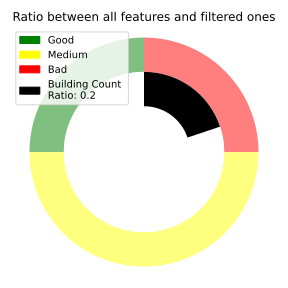

Marzahn-Hellersdorf
-------------------
Quality Label: red
Result Description: The ratio of the features (all: 42751.0) compared to features with
expected tags (matched: 9612.0) is 0.2.
Less than 25% of the features match the expected tags.



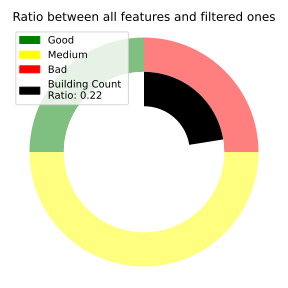

Neukölln
--------
Quality Label: yellow
Result Description: The ratio of the features (all: 38289.0) compared to features with
expected tags (matched: 15614.0) is 0.4.
Around 25-75% of the features match the expected tags.



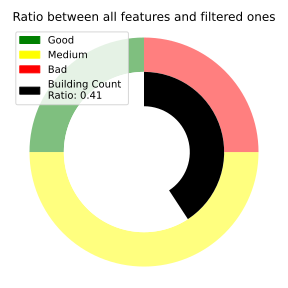

Tempelhof-Schöneberg
--------------------
Quality Label: yellow
Result Description: The ratio of the features (all: 44287.0) compared to features with
expected tags (matched: 21833.0) is 0.5.
Around 25-75% of the features match the expected tags.



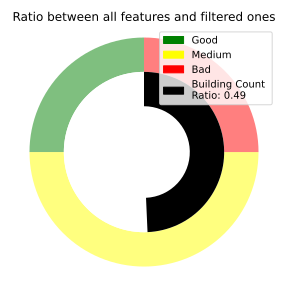

Friedrichshain-Kreuzberg
------------------------
Quality Label: green
Result Description: The ratio of the features (all: 12551.0) compared to features with
expected tags (matched: 10122.0) is 0.8.
More than 75% of the features match the expected tags.



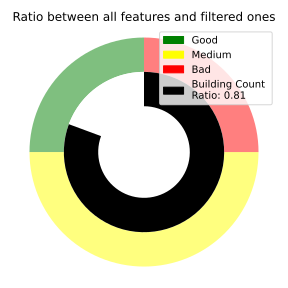

Treptow-Köpenick
----------------
Quality Label: yellow
Result Description: The ratio of the features (all: 53895.0) compared to features with
expected tags (matched: 15115.0) is 0.3.
Around 25-75% of the features match the expected tags.



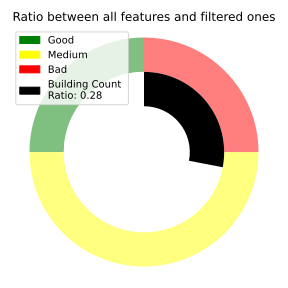

Steglitz-Zehlendorf
-------------------
Quality Label: red
Result Description: The ratio of the features (all: 56170.0) compared to features with
expected tags (matched: 11505.0) is 0.2.
Less than 25% of the features match the expected tags.



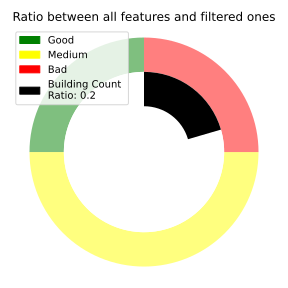

Mitte
-----
Quality Label: green
Result Description: The ratio of the features (all: 24754.0) compared to features with
expected tags (matched: 19785.0) is 0.8.
More than 75% of the features match the expected tags.



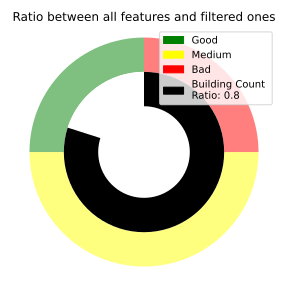

Spandau
-------
Quality Label: red
Result Description: The ratio of the features (all: 44840.0) compared to features with
expected tags (matched: 8350.0) is 0.2.
Less than 25% of the features match the expected tags.



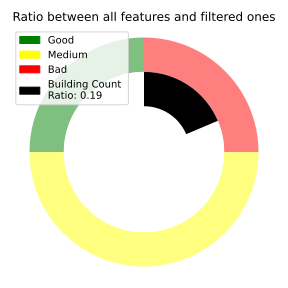

Reinickendorf
-------------
Quality Label: red
Result Description: The ratio of the features (all: 55709.0) compared to features with
expected tags (matched: 10073.0) is 0.2.
Less than 25% of the features match the expected tags.



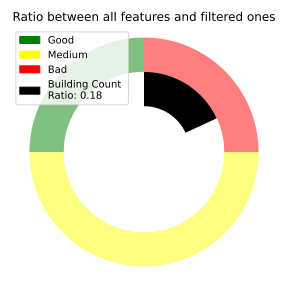

In [6]:
import json
import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

# load districts as GeoJSON FeatureCollection
with open("germany-berlin-districts.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "name": "TagsRatio",
    "layerKey": "building_count",
    "bpolys": bpolys,
    "includeSvg": True,
}

response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

features = response.json()["features"]
for feature in features:
    display_results(feature)